In [2]:
import pickle

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig

# Main computation libraries
import scipy.sparse as sp
import numpy as np

# Deep learning related imports
import torch

In [3]:
"""
    Contains constants needed for data loading and visualization.

"""

import os
import enum


# Supported datasets - only Cora in this notebook
class DatasetType(enum.Enum):
    CORA = 0

    
# Networkx is not precisely made with drawing as its main feature but I experimented with it a bit
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1


# We'll be dumping and reading the data from this directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CORA_PATH = os.path.join(DATA_DIR_PATH, 'cora')  # this is checked-in no need to make a directory

#
# Cora specific constants
#

# Thomas Kipf et al. first used this split in GCN paper and later Petar Veličković et al. in GAT paper
CORA_TRAIN_RANGE = [0, 140]  # we're using the first 140 nodes as the training nodes
CORA_VAL_RANGE = [140, 140+500]
CORA_TEST_RANGE = [1708, 1708+1000]
CORA_NUM_INPUT_FEATURES = 1433
CORA_NUM_CLASSES = 7

# Used whenever we need to visualzie points from different classes (t-SNE, CORA visualization)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

In [4]:
# First let's define these simple functions for loading/saving Pickle files - we need them for Cora

# All Cora data is stored as pickle
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

In [ ]:
def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'

    # Instead of dividing (like in normalize_features_dense()) we do multiplication with inverse sum of features.
    # Modern hardware (GPUs, TPUs, ASICs) is optimized for fast matrix multiplications! ^^ (* >> /)
    # shape = (N, FIN) -> (N, 1), where N number of nodes and FIN number of input features
    node_features_sum = np.array(node_features_sparse.sum(-1))  # sum features for every node feature vector

    # Make an inverse (remember * by 1/x is better (faster) then / by x)
    # shape = (N, 1) -> (N)
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    # Again certain sums will be 0 so 1/0 will give us inf so we replace those by 1 which is a neutral element for mul
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    # Create a diagonal matrix whose values on the diagonal come from node_features_inv_sum
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    # We return the normalized features.
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)

In [13]:
# visualizing
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora)
    in_degrees = np.zeros(num_of_nodes, dtype=int)
    out_degrees = np.zeros(num_of_nodes, dtype=int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment its out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given out-degree') 
    plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()


In [5]:
# We'll pass the training config dictionary a bit later
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CORA.name.lower():

        # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
        # shape = (N, 1)
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
        # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
        adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

        # Normalize the features (helps with training)
        node_features_csr = normalize_features_sparse(node_features_csr)
        num_of_nodes = len(node_labels_npy)

        # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
        # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
        topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True)

        # Note: topology is just a fancy way of naming the graph structure data 
        # (aside from edge index it could be in the form of an adjacency matrix)

        if should_visualize:  # network analysis and graph drawing
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)  # we'll define these in a second
            visualize_graph(topology, node_labels_npy, dataset_name)

        # Convert to dense PyTorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features_csr.todense(), device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

config = {
    'dataset_name': DatasetType.CORA.name,
    'should_visualize': False
}

node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

C:\Users\Peter\AppData\Local\Temp\ipykernel_26040\2525551710.py:6: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data = pickle.load(file)


torch.Size([2708, 1433]) torch.float32
torch.Size([2708]) torch.int64
torch.Size([2, 13264]) torch.int64
torch.Size([140]) torch.int64
torch.Size([500]) torch.int64
torch.Size([1000]) torch.int64


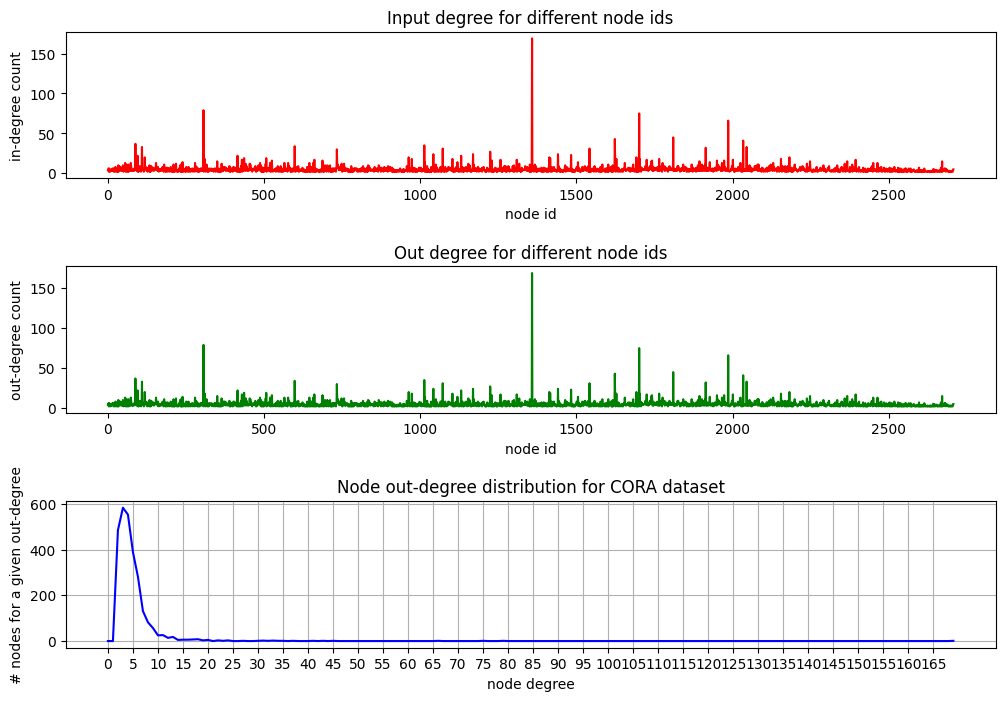

In [14]:
num_of_nodes = len(node_labels)
plot_in_out_degree_distributions(edge_index, num_of_nodes, config['dataset_name'])

In [15]:
"""
Check out this blog for available graph visualization tools:
    https://towardsdatascience.com/large-graph-visualization-tools-and-approaches-2b8758a1cd59

Basically depending on how big your graph is there may be better drawing tools than igraph.

Note: I unfortunatelly had to flatten this function since igraph is having some problems with Jupyter Notebook,
we'll only call it here so it's fine!

"""

dataset_name = config['dataset_name']
visualization_tool=GraphVisualizationTool.IGRAPH

if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))  # igraph requires this format

# Construct the igraph graph
ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

# Prepare the visualization settings dictionary
visual_style = {}

# Defines the size of the plot and margins
# go berserk here try (3000, 3000) it looks amazing in Jupyter!!! (you'll have to adjust the vertex_size though!)
visual_style["bbox"] = (700, 700)
visual_style["margin"] = 5

# I've chosen the edge thickness such that it's proportional to the number of shortest paths (geodesics)
# that go through a certain edge in our graph (edge_betweenness function, a simple ad hoc heuristic)

# line1: I use log otherwise some edges will be too thick and others not visible at all
# edge_betweeness returns < 1 for certain edges that's why I use clip as log would be negative for those edges
# line2: Normalize so that the thickest edge is 1 otherwise edges appear too thick on the chart
# line3: The idea here is to make the strongest edge stay stronger than others, 6 just worked, don't dwell on it

edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness())+1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_style["edge_width"] = edge_weights

# A simple heuristic for vertex size. Size ~ (degree / 4) (it gave nice results I tried log and sqrt as well)
visual_style["vertex_size"] = [deg / 4 for deg in ig_graph.degree()]

# This is the only part that's Cora specific as Cora has 7 labels
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in node_labels_np]
else:
    print('Feel free to add custom color scheme for your specific dataset. Using igraph default coloring.')

# Set the layout - the way the graph is presented on a 2D chart. Graph drawing is a subfield for itself!
# I used "Kamada Kawai" a force-directed method, this family of methods are based on physical system simulation.
# (layout_drl also gave nice results for Cora)
visual_style["layout"] = ig_graph.layout_kamada_kawai()

print('Plotting results ... (it may take couple of seconds).')
ig.plot(ig_graph, **visual_style)

# This website has got some awesome visualizations check it out:
# http://networkrepository.com/graphvis.php?d=./data/gsm50/labeled/cora.edges

Plotting results ... (it may take couple of seconds).


AttributeError: Plotting not available; please install pycairo or cairocffi